
### Imports

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import time

from pathlib import Path
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, Subset

from datasets import SurfaceDataset
from helpers import EarlyStopper
from models import CNNSurfaceClassifier

### Device

In [2]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

### Seed

In [3]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

### Constants

In [4]:
BATCH_SIZE = 32
INPUT_SIZE = 6
NUM_EPOCHS = 100
DATA_DIR = Path('../data/train_set/')
HISTORY_DIR = Path('../results/biases/')
LOOKBACK = 2.
SAMPLING_FREQUENCY = 100.
DATASET_FREQUENCY = 200.
SUBSET = ('imu',)
CONFIGURATIONS = ('4W',)
TRAIN_SIZES = np.arange(2, 9) / 10

### Load and split data

In [5]:
with open('../data/labels.json') as fp:
    labels = json.load(fp)

In [6]:
dataset = [(DATA_DIR.joinpath(key + '.csv'), values['surface']) for key, values in labels.items() if values['kinematics'] in CONFIGURATIONS and values['spacing'] == 'R1' and 'T1' in values['trajectory']]

In [7]:
X = pd.Series([run[0] for run in dataset], name='bag_name')
y_primary = [run[1] for run in dataset]

In [8]:
# y_secondary = ['slippery' if label in ('1_Panele', '5_Spienione_PCV', '6_Linoleum')
#                else 'grippy' if label in ('3_Wykladzina_jasna', '8_Pusta_plyta', '9_podklady')
#                else 'neutral' for label in y_primary]
y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
               else 'grippy' if label in ('5_Spienione_PCV', '8_Pusta_plyta', '9_podklady', '10_Mata_ukladana')
               else 'neutral' for label in y_primary] # Pawel set
# y_secondary = ['slippery' if label in ('3_Wykladzina_jasna', '4_Trawa')
#                else 'grippy' if label in ('2_Wykladzina_czarna', '5_Spienione_PCV', '9_podklady', '10_Mata_ukladana')
#                else 'neutral' for label in y_primary] # Clustering set

In [9]:
lb = LabelBinarizer()
lb.fit(y_primary)
classes = lb.classes_
num_classes = len(classes)
y = lb.transform(y_primary)
y = y.reshape(-1, num_classes)

### Custom datasets

In [10]:
cv_data = SurfaceDataset(X, y, sample_freq=SAMPLING_FREQUENCY, data_freq=DATASET_FREQUENCY, lookback=LOOKBACK, subset=SUBSET)

### Loss function

In [11]:
criterion = nn.CrossEntropyLoss()

### Training loop

In [12]:
history = {}

for train_size in TRAIN_SIZES:
    print(f"Train size: {train_size}")
    split_history = {}
    
    sss = StratifiedShuffleSplit(test_size=int(0.2 * len(cv_data)), train_size=int(train_size * len(cv_data)))
    for i, (train_index, testing_index) in enumerate(sss.split(X, y)):
        # Initialize the model in each split
        cnn_model = CNNSurfaceClassifier(input_size=INPUT_SIZE, output_size=num_classes).to(device)
        # Initialize optimizer in each split
        optimizer = torch.optim.Adam(
            cnn_model.parameters(),
            lr=1e-3,
            eps=1e-6,
            weight_decay=1e-3,
            )
        # Initialize scheduler in each split
        scheduler = ExponentialLR(optimizer, gamma=0.9)
        # Initialize early stopping
        early_stopper = EarlyStopper()
        
        # Separate validation hold-out fold from test subset
        val_index, test_index = train_test_split(testing_index, test_size=0.5, stratify=y[testing_index])
        
        train_dataloader = DataLoader(
            Subset(cv_data, train_index),
            batch_size=BATCH_SIZE,
            worker_init_fn=seed_worker,
            generator=g,
            shuffle=True,
        )
        val_dataloader = DataLoader(
            Subset(cv_data, val_index),
            batch_size=BATCH_SIZE,
            worker_init_fn=seed_worker,
            generator=g,
        )
        test_dataloader = DataLoader(
            Subset(cv_data, test_index),
            batch_size=BATCH_SIZE,
            worker_init_fn=seed_worker,
            generator=g,
        )
        
        train_batches = len(train_dataloader)
        val_batches = len(val_dataloader)
    
        for epoch in range(NUM_EPOCHS):
            running_train_loss = 0.0
            running_val_loss = 0.0
            
            pbar = tqdm(train_dataloader, total=train_batches)
            cnn_model.train()
            for idx, (batch_x, batch_y) in enumerate(pbar):
                optimizer.zero_grad()
                
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                batch_x = batch_x.permute(0, 2, 1)
                train_outputs = cnn_model(batch_x)
                train_loss = criterion(train_outputs, batch_y)
                running_train_loss += train_loss
        
                # Backward pass
                train_loss.backward()
                optimizer.step()
        
                pbar.set_description(f"Fold {i + 1}/{sss.get_n_splits()}, Epoch {epoch + 1}/{NUM_EPOCHS}, Training loss: {running_train_loss / (idx + 1):.2E}")
            scheduler.step()
            
            pbar_val = tqdm(val_dataloader, total=val_batches)
            cnn_model.eval()
            with torch.no_grad():
                for idx, (batch_x_val, batch_y_val) in enumerate(pbar_val):
                    batch_x_val, batch_y_val = batch_x_val.to(device), batch_y_val.to(device)
                    batch_x_val = batch_x_val.permute(0, 2, 1)
                    val_outputs = cnn_model(batch_x_val)
                    val_loss = criterion(val_outputs, batch_y_val)
                    running_val_loss += val_loss
                                    
                    pbar_val.set_description(f"Fold {i + 1}/{sss.get_n_splits()}, Epoch {epoch + 1}/{NUM_EPOCHS}, Validation loss: {running_val_loss / (idx + 1):.2E}")
                    
            validation_loss = running_val_loss / (idx + 1)
            if early_stopper.early_stop(validation_loss):   
                print(f"Split {i + 1} ended on epoch {epoch + 1 - early_stopper.patience}!")
                break
            if early_stopper.counter == 0:
                best_model = cnn_model.state_dict()
            
        cnn_model.load_state_dict(best_model)  
        
        train_batches = len(train_dataloader)
        y_true_train, y_pred_train = [], []
        running_train_loss = 0.0
        
        pbar_train = tqdm(train_dataloader, total=train_batches)
        cnn_model.eval()
        with torch.no_grad():
            for idx, (batch_x_train, batch_y_train) in enumerate(pbar_train):
                batch_x_train, batch_y_train = batch_x_train.to(device), batch_y_train.to(device)
                batch_x_train = batch_x_train.permute(0, 2, 1)
                train_outputs = cnn_model(batch_x_train)
                train_loss = criterion(train_outputs, batch_y_train)
                running_train_loss += train_loss
                
                y_true_train.extend(torch.argmax(batch_y_train, dim=1).cpu().numpy())
                y_pred_train.extend(torch.argmax(train_outputs, dim=1).cpu().numpy())
                
                pbar_train.set_description(f"Fold {i + 1}/{sss.get_n_splits()}, Train loss: {running_train_loss / (idx + 1):.2E}")
        
        test_batches = len(test_dataloader)
        y_true_test, y_pred_test = [], []
        running_test_loss = 0.0
        
        pbar_test = tqdm(test_dataloader, total=test_batches)
        cnn_model.eval()
        with torch.no_grad():
            for idx, (batch_x_test, batch_y_test) in enumerate(pbar_test):
                batch_x_test, batch_y_test = batch_x_test.to(device), batch_y_test.to(device)
                batch_x_test = batch_x_test.permute(0, 2, 1)
                test_outputs = cnn_model(batch_x_test)
                test_loss = criterion(test_outputs, batch_y_test)
                running_test_loss += test_loss
                
                y_true_test.extend(torch.argmax(batch_y_test, dim=1).cpu().numpy())
                y_pred_test.extend(torch.argmax(test_outputs, dim=1).cpu().numpy())
                
                pbar_test.set_description(f"Fold {i + 1}/{sss.get_n_splits()}, Test loss: {running_test_loss / (idx + 1):.2E}")
        
        split_history[i + 1] = {
            'train_accuracy': accuracy_score(y_true_train, y_pred_train),
            'train_f1_score': f1_score(y_true_train, y_pred_train, average='macro'),
            'test_accuracy': accuracy_score(y_true_test, y_pred_test),
            'test_f1_score': f1_score(y_true_test, y_pred_test, average='macro'),
        }
    history[train_size] = split_history

history_filename = '_'.join(CONFIGURATIONS + SUBSET) + '_' + time.strftime("%Y-%m-%d-%H-%M-%S")
json.dump(history, open(HISTORY_DIR / f'{history_filename}.json', 'w'))

Train size: 0.2


Fold 1/10, Epoch 1/100, Training loss: 2.26E+00: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]
Fold 1/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  1.47it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.93E+00: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.85it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.66E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 1/10, Epoch 3/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.53E+00: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
Fold 1/10, Epoch 4/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.56E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 1/10, Epoch 5/100, Validation loss: 2.20E+00: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 34!


Fold 2/10, Epoch 1/100, Training loss: 2.14E+00: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.91E+00: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.77E+00: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
Fold 2/10, Epoch 3/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.61E+00: 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]
Fold 2/10, Epoch 4/100, Validation loss: 2.33E+00: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.53E+00: 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]
Fold 2/10, Epoch 5/100, Validation loss: 2.36E+00: 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 30!


Fold 3/10, Epoch 1/100, Training loss: 2.06E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.94E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.66E+00: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
Fold 3/10, Epoch 3/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  3.19it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.61E+00: 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]
Fold 3/10, Epoch 4/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.51E+00: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]
Fold 3/10, Epoch 5/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 28!


Fold 4/10, Epoch 1/100, Training loss: 2.20E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.86E+00: 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.73E+00: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]
Fold 4/10, Epoch 3/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.65E+00: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]
Fold 4/10, Epoch 4/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.51E+00: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
Fold 4/10, Epoch 5/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 31!


Fold 5/10, Epoch 1/100, Training loss: 2.21E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.82E+00: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.68E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.54E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 5/10, Epoch 4/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.47E+00: 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]
Fold 5/10, Epoch 5/100, Validation loss: 2.20E+00: 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 23!


Fold 6/10, Epoch 1/100, Training loss: 2.27E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.75E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.60E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  3.32it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.58E+00: 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]
Fold 6/10, Epoch 4/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.49E+00: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
Fold 6/10, Epoch 5/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 33!


Fold 7/10, Epoch 1/100, Training loss: 2.22E+00: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  3.20it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.87E+00: 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.79E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 7/10, Epoch 3/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.51E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 7/10, Epoch 4/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.46E+00: 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]
Fold 7/10, Epoch 5/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 35!


Fold 8/10, Epoch 1/100, Training loss: 2.35E+00: 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  3.13it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.97E+00: 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.74E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  3.17it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.62E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 8/10, Epoch 4/100, Validation loss: 2.21E+00: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.51E+00: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
Fold 8/10, Epoch 5/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  3.09it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 23!


Fold 9/10, Epoch 1/100, Training loss: 2.28E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.78E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  3.18it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.73E+00: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.55E+00: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]
Fold 9/10, Epoch 4/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.56E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 9/10, Epoch 5/100, Validation loss: 2.20E+00: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 19!


Fold 10/10, Epoch 1/100, Training loss: 2.28E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  3.03it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.90E+00: 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.60E+00: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
Fold 10/10, Epoch 3/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  3.10it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.60E+00: 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]
Fold 10/10, Epoch 4/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  2.23it/s]
Fold 10/10, Epoch 5/100, Training loss: 1.57E+00: 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]
Fold 10/10, Epoch 5/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  3.05it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 45!


Fold 10/10, Test loss: 1.04E+00: 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]


Train size: 0.3


Fold 1/10, Epoch 1/100, Training loss: 2.19E+00: 100%|██████████| 3/3 [00:01<00:00,  1.56it/s]
Fold 1/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  1.93it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.76E+00: 100%|██████████| 3/3 [00:01<00:00,  1.50it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.66E+00: 100%|██████████| 3/3 [00:01<00:00,  1.60it/s]
Fold 1/10, Epoch 3/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  2.14it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.52E+00: 100%|██████████| 3/3 [00:01<00:00,  1.61it/s]
Fold 1/10, Epoch 4/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.54E+00: 100%|██████████| 3/3 [00:01<00:00,  1.58it/s]
Fold 1/10, Epoch 5/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  2.05it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 19!


Fold 2/10, Epoch 1/100, Training loss: 2.28E+00: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.47it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.80E+00: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.72E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 2/10, Epoch 3/100, Validation loss: 2.21E+00: 100%|██████████| 1/1 [00:00<00:00,  2.37it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.54E+00: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]
Fold 2/10, Epoch 4/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.44E+00: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]
Fold 2/10, Epoch 5/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 20!


Fold 3/10, Epoch 1/100, Training loss: 2.14E+00: 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.62E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.55E+00: 100%|██████████| 3/3 [00:01<00:00,  1.68it/s]
Fold 3/10, Epoch 3/100, Validation loss: 2.20E+00: 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.49E+00: 100%|██████████| 3/3 [00:01<00:00,  1.76it/s]
Fold 3/10, Epoch 4/100, Validation loss: 2.19E+00: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.34E+00: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
Fold 3/10, Epoch 5/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 17!


Fold 4/10, Epoch 1/100, Training loss: 2.24E+00: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.84E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  2.31it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.73E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 4/10, Epoch 3/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.54E+00: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]
Fold 4/10, Epoch 4/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.52E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 4/10, Epoch 5/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 36!


Fold 5/10, Epoch 1/100, Training loss: 2.19E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.76E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.62E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.56E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 5/10, Epoch 4/100, Validation loss: 2.21E+00: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.32E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 5/10, Epoch 5/100, Validation loss: 2.14E+00: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 17!


Fold 6/10, Epoch 1/100, Training loss: 2.34E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.78E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.63E+00: 100%|██████████| 3/3 [00:01<00:00,  1.79it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.53E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 6/10, Epoch 4/100, Validation loss: 2.19E+00: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.52E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 6/10, Epoch 5/100, Validation loss: 2.10E+00: 100%|██████████| 1/1 [00:00<00:00,  2.07it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 32!


Fold 7/10, Epoch 1/100, Training loss: 2.10E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.74E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.61E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 7/10, Epoch 3/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.60E+00: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
Fold 7/10, Epoch 4/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.41E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 7/10, Epoch 5/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 35!


Fold 8/10, Epoch 1/100, Training loss: 2.08E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.81E+00: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.52E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  2.39it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.47E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 8/10, Epoch 4/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  2.32it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.37E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 8/10, Epoch 5/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 28!


Fold 9/10, Epoch 1/100, Training loss: 2.23E+00: 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.84E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.73E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.59E+00: 100%|██████████| 3/3 [00:01<00:00,  1.69it/s]
Fold 9/10, Epoch 4/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.46E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 9/10, Epoch 5/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  2.40it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 18!


Fold 10/10, Epoch 1/100, Training loss: 2.16E+00: 100%|██████████| 3/3 [00:01<00:00,  1.66it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  2.38it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.76E+00: 100%|██████████| 3/3 [00:01<00:00,  1.78it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.64E+00: 100%|██████████| 3/3 [00:01<00:00,  1.81it/s]
Fold 10/10, Epoch 3/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  1.84it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.56E+00: 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]
Fold 10/10, Epoch 4/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]
Fold 10/10, Epoch 5/100, Training loss: 1.43E+00: 100%|██████████| 3/3 [00:01<00:00,  1.82it/s]
Fold 10/10, Epoch 5/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  2.35it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 35!


Fold 10/10, Test loss: 8.64E-01: 100%|██████████| 3/3 [00:01<00:00,  2.13it/s]


Train size: 0.4


Fold 1/10, Epoch 1/100, Training loss: 2.15E+00: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Fold 1/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.82E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.75E+00: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Fold 1/10, Epoch 3/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.42E+00: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
Fold 1/10, Epoch 4/100, Validation loss: 2.15E+00: 100%|██████████| 1/1 [00:00<00:00,  1.83it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.54E+00: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
Fold 1/10, Epoch 5/100, Validation loss: 2.08E+00: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 28!


Fold 2/10, Epoch 1/100, Training loss: 2.07E+00: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.70E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.52E+00: 100%|██████████| 4/4 [00:02<00:00,  1.81it/s]
Fold 2/10, Epoch 3/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.45E+00: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
Fold 2/10, Epoch 4/100, Validation loss: 2.13E+00: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.31E+00: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Fold 2/10, Epoch 5/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 21!


Fold 3/10, Epoch 1/100, Training loss: 2.17E+00: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.85E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.81E+00: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
Fold 3/10, Epoch 3/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.61E+00: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
Fold 3/10, Epoch 4/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  1.73it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.58E+00: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Fold 3/10, Epoch 5/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 36!


Fold 4/10, Epoch 1/100, Training loss: 2.14E+00: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  1.70it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.87E+00: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.58E+00: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
Fold 4/10, Epoch 3/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  1.78it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.53E+00: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Fold 4/10, Epoch 4/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.44E+00: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
Fold 4/10, Epoch 5/100, Validation loss: 2.10E+00: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 27!


Fold 5/10, Epoch 1/100, Training loss: 2.22E+00: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.84E+00: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.58E+00: 100%|██████████| 4/4 [00:02<00:00,  1.80it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.40E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 5/10, Epoch 4/100, Validation loss: 2.20E+00: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.63E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 5/10, Epoch 5/100, Validation loss: 2.10E+00: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 24!


Fold 6/10, Epoch 1/100, Training loss: 2.11E+00: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.81E+00: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.55E+00: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.15E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.41E+00: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
Fold 6/10, Epoch 4/100, Validation loss: 2.11E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.44E+00: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Fold 6/10, Epoch 5/100, Validation loss: 1.89E+00: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 21!


Fold 7/10, Epoch 1/100, Training loss: 2.11E+00: 100%|██████████| 4/4 [00:02<00:00,  1.74it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 1/1 [00:00<00:00,  1.80it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.70E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.25E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.53E+00: 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]
Fold 7/10, Epoch 3/100, Validation loss: 2.20E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.57E+00: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
Fold 7/10, Epoch 4/100, Validation loss: 2.16E+00: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.40E+00: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
Fold 7/10, Epoch 5/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 60!


Fold 8/10, Epoch 1/100, Training loss: 2.12E+00: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.79E+00: 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.24E+00: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.57E+00: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:00<00:00,  1.75it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.43E+00: 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]
Fold 8/10, Epoch 4/100, Validation loss: 2.11E+00: 100%|██████████| 1/1 [00:00<00:00,  1.71it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.36E+00: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Fold 8/10, Epoch 5/100, Validation loss: 1.98E+00: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 15!


Fold 9/10, Epoch 1/100, Training loss: 2.12E+00: 100%|██████████| 4/4 [00:02<00:00,  1.72it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.80E+00: 100%|██████████| 4/4 [00:02<00:00,  1.73it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.23E+00: 100%|██████████| 1/1 [00:00<00:00,  1.76it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.55E+00: 100%|██████████| 4/4 [00:02<00:00,  1.77it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.19E+00: 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.39E+00: 100%|██████████| 4/4 [00:02<00:00,  1.70it/s]
Fold 9/10, Epoch 4/100, Validation loss: 2.17E+00: 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.41E+00: 100%|██████████| 4/4 [00:02<00:00,  1.76it/s]
Fold 9/10, Epoch 5/100, Validation loss: 2.12E+00: 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 21!


Fold 10/10, Epoch 1/100, Training loss: 2.06E+00: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.29E+00: 100%|██████████| 1/1 [00:00<00:00,  1.68it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.76E+00: 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.28E+00: 100%|██████████| 1/1 [00:00<00:00,  1.79it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.64E+00: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Fold 10/10, Epoch 3/100, Validation loss: 2.22E+00: 100%|██████████| 1/1 [00:00<00:00,  1.81it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.44E+00: 100%|██████████| 4/4 [00:02<00:00,  1.75it/s]
Fold 10/10, Epoch 4/100, Validation loss: 2.18E+00: 100%|██████████| 1/1 [00:01<00:00,  1.40s/it]
Fold 10/10, Epoch 5/100, Training loss: 1.32E+00: 100%|██████████| 4/4 [00:04<00:00,  1.01s/it]
Fold 10/10, Epoch 5/100, Validation loss: 2.04E+00: 100%|██████████| 1/1 [00:00<00:00,  1.42it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 28!


Fold 10/10, Test loss: 7.30E-01: 100%|██████████| 3/3 [00:01<00:00,  1.71it/s]


Train size: 0.5


Fold 1/10, Epoch 1/100, Training loss: 2.03E+00: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
Fold 1/10, Epoch 1/100, Validation loss: 2.25E+00: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.72E+00: 100%|██████████| 5/5 [00:03<00:00,  1.27it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.58E+00: 100%|██████████| 5/5 [00:04<00:00,  1.21it/s]
Fold 1/10, Epoch 3/100, Validation loss: 2.11E+00: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.57E+00: 100%|██████████| 5/5 [00:03<00:00,  1.37it/s]
Fold 1/10, Epoch 4/100, Validation loss: 2.03E+00: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.33E+00: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
Fold 1/10, Epoch 5/100, Validation loss: 1.81E+00: 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 29!


Fold 2/10, Epoch 1/100, Training loss: 2.13E+00: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.30E+00: 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.66E+00: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.34E+00: 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.58E+00: 100%|██████████| 5/5 [00:03<00:00,  1.41it/s]
Fold 2/10, Epoch 3/100, Validation loss: 2.45E+00: 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.56E+00: 100%|██████████| 5/5 [00:03<00:00,  1.39it/s]
Fold 2/10, Epoch 4/100, Validation loss: 2.48E+00: 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.45E+00: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
Fold 2/10, Epoch 5/100, Validation loss: 2.28E+00: 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 27!


Fold 3/10, Epoch 1/100, Training loss: 2.08E+00: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.64E+00: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.08E+00: 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.52E+00: 100%|██████████| 5/5 [00:03<00:00,  1.31it/s]
Fold 3/10, Epoch 3/100, Validation loss: 1.88E+00: 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.45E+00: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
Fold 3/10, Epoch 4/100, Validation loss: 1.84E+00: 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.36E+00: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
Fold 3/10, Epoch 5/100, Validation loss: 1.74E+00: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 25!


Fold 4/10, Epoch 1/100, Training loss: 2.18E+00: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.32E+00: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.66E+00: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.51E+00: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.56E+00: 100%|██████████| 5/5 [00:03<00:00,  1.34it/s]
Fold 4/10, Epoch 3/100, Validation loss: 2.62E+00: 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.47E+00: 100%|██████████| 5/5 [00:03<00:00,  1.32it/s]
Fold 4/10, Epoch 4/100, Validation loss: 2.29E+00: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.31E+00: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]
Fold 4/10, Epoch 5/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 31!


Fold 5/10, Epoch 1/100, Training loss: 2.11E+00: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.68E+00: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.59E+00: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.39E+00: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
Fold 5/10, Epoch 4/100, Validation loss: 2.25E+00: 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.33E+00: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
Fold 5/10, Epoch 5/100, Validation loss: 2.50E+00: 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 32!


Fold 6/10, Epoch 1/100, Training loss: 2.06E+00: 100%|██████████| 5/5 [00:03<00:00,  1.60it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.31E+00: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.76E+00: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.32E+00: 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.60E+00: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.10E+00: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.34E+00: 100%|██████████| 5/5 [00:03<00:00,  1.48it/s]
Fold 6/10, Epoch 4/100, Validation loss: 2.06E+00: 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.43E+00: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
Fold 6/10, Epoch 5/100, Validation loss: 1.85E+00: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 42!


Fold 7/10, Epoch 1/100, Training loss: 2.06E+00: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.70E+00: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.13E+00: 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.47E+00: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
Fold 7/10, Epoch 3/100, Validation loss: 2.13E+00: 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.50E+00: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
Fold 7/10, Epoch 4/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.39E+00: 100%|██████████| 5/5 [00:03<00:00,  1.56it/s]
Fold 7/10, Epoch 5/100, Validation loss: 2.06E+00: 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 40!


Fold 8/10, Epoch 1/100, Training loss: 2.08E+00: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.23E+00: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.64E+00: 100%|██████████| 5/5 [00:03<00:00,  1.46it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.14E+00: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.66E+00: 100%|██████████| 5/5 [00:03<00:00,  1.61it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.16E+00: 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.47E+00: 100%|██████████| 5/5 [00:03<00:00,  1.57it/s]
Fold 8/10, Epoch 4/100, Validation loss: 1.99E+00: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.38E+00: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
Fold 8/10, Epoch 5/100, Validation loss: 1.87E+00: 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 21!


Fold 9/10, Epoch 1/100, Training loss: 2.19E+00: 100%|██████████| 5/5 [00:03<00:00,  1.58it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.31E+00: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.76E+00: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.31E+00: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.57E+00: 100%|██████████| 5/5 [00:03<00:00,  1.40it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.28E+00: 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.39E+00: 100%|██████████| 5/5 [00:03<00:00,  1.62it/s]
Fold 9/10, Epoch 4/100, Validation loss: 2.35E+00: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.36E+00: 100%|██████████| 5/5 [00:03<00:00,  1.51it/s]
Fold 9/10, Epoch 5/100, Validation loss: 1.86E+00: 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 23!


Fold 10/10, Epoch 1/100, Training loss: 2.18E+00: 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.80E+00: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.19E+00: 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.58E+00: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
Fold 10/10, Epoch 3/100, Validation loss: 2.13E+00: 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.57E+00: 100%|██████████| 5/5 [00:03<00:00,  1.55it/s]
Fold 10/10, Epoch 4/100, Validation loss: 2.09E+00: 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]
Fold 10/10, Epoch 5/100, Training loss: 1.34E+00: 100%|██████████| 5/5 [00:03<00:00,  1.54it/s]
Fold 10/10, Epoch 5/100, Validation loss: 1.95E+00: 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 35!


Fold 10/10, Test loss: 1.00E+00: 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


Train size: 0.6


Fold 1/10, Epoch 1/100, Training loss: 2.02E+00: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]
Fold 1/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.72E+00: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.16E+00: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.59E+00: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]
Fold 1/10, Epoch 3/100, Validation loss: 2.19E+00: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.33E+00: 100%|██████████| 6/6 [00:03<00:00,  1.54it/s]
Fold 1/10, Epoch 4/100, Validation loss: 2.35E+00: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.48E+00: 100%|██████████| 6/6 [00:03<00:00,  1.60it/s]
Fold 1/10, Epoch 5/100, Validation loss: 1.79E+00: 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 17!


Fold 2/10, Epoch 1/100, Training loss: 2.09E+00: 100%|██████████| 6/6 [00:04<00:00,  1.42it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.62E+00: 100%|██████████| 6/6 [00:04<00:00,  1.45it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.23E+00: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.57E+00: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]
Fold 2/10, Epoch 3/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.50E+00: 100%|██████████| 6/6 [00:04<00:00,  1.40it/s]
Fold 2/10, Epoch 4/100, Validation loss: 1.84E+00: 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.34E+00: 100%|██████████| 6/6 [00:04<00:00,  1.35it/s]
Fold 2/10, Epoch 5/100, Validation loss: 1.65E+00: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 28!


Fold 3/10, Epoch 1/100, Training loss: 2.03E+00: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.23E+00: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.60E+00: 100%|██████████| 6/6 [00:04<00:00,  1.24it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.15E+00: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.61E+00: 100%|██████████| 6/6 [00:04<00:00,  1.25it/s]
Fold 3/10, Epoch 3/100, Validation loss: 2.01E+00: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.49E+00: 100%|██████████| 6/6 [00:04<00:00,  1.36it/s]
Fold 3/10, Epoch 4/100, Validation loss: 1.97E+00: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.36E+00: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
Fold 3/10, Epoch 5/100, Validation loss: 1.53E+00: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 45!


Fold 4/10, Epoch 1/100, Training loss: 2.02E+00: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.69E+00: 100%|██████████| 6/6 [00:03<00:00,  1.51it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.61E+00: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
Fold 4/10, Epoch 3/100, Validation loss: 1.94E+00: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.32E+00: 100%|██████████| 6/6 [00:04<00:00,  1.22it/s]
Fold 4/10, Epoch 4/100, Validation loss: 1.55E+00: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.25E+00: 100%|██████████| 6/6 [00:04<00:00,  1.29it/s]
Fold 4/10, Epoch 5/100, Validation loss: 1.47E+00: 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 25!


Fold 5/10, Epoch 1/100, Training loss: 2.04E+00: 100%|██████████| 6/6 [00:03<00:00,  1.58it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.62E+00: 100%|██████████| 6/6 [00:04<00:00,  1.47it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.47E+00: 100%|██████████| 6/6 [00:04<00:00,  1.46it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.10E+00: 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.39E+00: 100%|██████████| 6/6 [00:04<00:00,  1.23it/s]
Fold 5/10, Epoch 4/100, Validation loss: 2.06E+00: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.30E+00: 100%|██████████| 6/6 [00:04<00:00,  1.37it/s]
Fold 5/10, Epoch 5/100, Validation loss: 1.74E+00: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 45!


Fold 6/10, Epoch 1/100, Training loss: 2.00E+00: 100%|██████████| 6/6 [00:03<00:00,  1.55it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.68E+00: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.46E+00: 100%|██████████| 6/6 [00:03<00:00,  1.52it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.11E+00: 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.31E+00: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
Fold 6/10, Epoch 4/100, Validation loss: 1.88E+00: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.39E+00: 100%|██████████| 6/6 [00:04<00:00,  1.50it/s]
Fold 6/10, Epoch 5/100, Validation loss: 1.62E+00: 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 43!


Fold 7/10, Epoch 1/100, Training loss: 2.01E+00: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.73E+00: 100%|██████████| 6/6 [00:03<00:00,  1.56it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.15E+00: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.55E+00: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]
Fold 7/10, Epoch 3/100, Validation loss: 1.96E+00: 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.54E+00: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]
Fold 7/10, Epoch 4/100, Validation loss: 1.83E+00: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.36E+00: 100%|██████████| 6/6 [00:03<00:00,  1.66it/s]
Fold 7/10, Epoch 5/100, Validation loss: 1.82E+00: 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 29!


Fold 8/10, Epoch 1/100, Training loss: 1.99E+00: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.73E+00: 100%|██████████| 6/6 [00:04<00:00,  1.49it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.23E+00: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.51E+00: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.21E+00: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.40E+00: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]
Fold 8/10, Epoch 4/100, Validation loss: 1.94E+00: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.27E+00: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]
Fold 8/10, Epoch 5/100, Validation loss: 1.73E+00: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 43!


Fold 9/10, Epoch 1/100, Training loss: 2.01E+00: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.75E+00: 100%|██████████| 6/6 [00:03<00:00,  1.59it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.50E+00: 100%|██████████| 6/6 [00:03<00:00,  1.62it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.20E+00: 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.49E+00: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Fold 9/10, Epoch 4/100, Validation loss: 1.99E+00: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.37E+00: 100%|██████████| 6/6 [00:03<00:00,  1.63it/s]
Fold 9/10, Epoch 5/100, Validation loss: 1.71E+00: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 18!


Fold 10/10, Epoch 1/100, Training loss: 2.15E+00: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.73E+00: 100%|██████████| 6/6 [00:03<00:00,  1.65it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.19E+00: 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.70E+00: 100%|██████████| 6/6 [00:03<00:00,  1.61it/s]
Fold 10/10, Epoch 3/100, Validation loss: 2.16E+00: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.63E+00: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
Fold 10/10, Epoch 4/100, Validation loss: 2.08E+00: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]
Fold 10/10, Epoch 5/100, Training loss: 1.41E+00: 100%|██████████| 6/6 [00:03<00:00,  1.64it/s]
Fold 10/10, Epoch 5/100, Validation loss: 1.86E+00: 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 29!


Fold 10/10, Test loss: 5.84E-01: 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]


Train size: 0.7


Fold 1/10, Epoch 1/100, Training loss: 1.93E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 1/10, Epoch 1/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.69E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.06E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.47E+00: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
Fold 1/10, Epoch 3/100, Validation loss: 2.12E+00: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.68E+00: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
Fold 1/10, Epoch 4/100, Validation loss: 2.09E+00: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.53E+00: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
Fold 1/10, Epoch 5/100, Validation loss: 1.65E+00: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 55!


Fold 2/10, Epoch 1/100, Training loss: 2.07E+00: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.73E+00: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.08E+00: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.52E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 2/10, Epoch 3/100, Validation loss: 2.00E+00: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.42E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 2/10, Epoch 4/100, Validation loss: 1.74E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.27E+00: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
Fold 2/10, Epoch 5/100, Validation loss: 1.48E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 24!


Fold 3/10, Epoch 1/100, Training loss: 2.08E+00: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.20E+00: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.69E+00: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.00E+00: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.59E+00: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
Fold 3/10, Epoch 3/100, Validation loss: 1.88E+00: 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.41E+00: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
Fold 3/10, Epoch 4/100, Validation loss: 1.83E+00: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.57E+00: 100%|██████████| 7/7 [00:04<00:00,  1.65it/s]
Fold 3/10, Epoch 5/100, Validation loss: 1.20E+00: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 25!


Fold 4/10, Epoch 1/100, Training loss: 1.91E+00: 100%|██████████| 7/7 [00:04<00:00,  1.64it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.73E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.36E+00: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
Fold 4/10, Epoch 3/100, Validation loss: 2.12E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.37E+00: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]
Fold 4/10, Epoch 4/100, Validation loss: 1.81E+00: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.39E+00: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
Fold 4/10, Epoch 5/100, Validation loss: 1.63E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 35!


Fold 5/10, Epoch 1/100, Training loss: 1.93E+00: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.66E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.08E+00: 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.46E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.09E+00: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.52E+00: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
Fold 5/10, Epoch 4/100, Validation loss: 1.73E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.41E+00: 100%|██████████| 7/7 [00:04<00:00,  1.63it/s]
Fold 5/10, Epoch 5/100, Validation loss: 1.45E+00: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 19!


Fold 6/10, Epoch 1/100, Training loss: 2.02E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.74E+00: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.68E+00: 100%|██████████| 7/7 [00:04<00:00,  1.49it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.43E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 6/10, Epoch 4/100, Validation loss: 1.80E+00: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.52E+00: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
Fold 6/10, Epoch 5/100, Validation loss: 1.44E+00: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 29!


Fold 7/10, Epoch 1/100, Training loss: 1.89E+00: 100%|██████████| 7/7 [00:04<00:00,  1.51it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.28E+00: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.74E+00: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.06E+00: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.49E+00: 100%|██████████| 7/7 [00:04<00:00,  1.57it/s]
Fold 7/10, Epoch 3/100, Validation loss: 1.98E+00: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.50E+00: 100%|██████████| 7/7 [00:04<00:00,  1.62it/s]
Fold 7/10, Epoch 4/100, Validation loss: 1.69E+00: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.39E+00: 100%|██████████| 7/7 [00:04<00:00,  1.61it/s]
Fold 7/10, Epoch 5/100, Validation loss: 1.52E+00: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 54!


Fold 8/10, Epoch 1/100, Training loss: 2.05E+00: 100%|██████████| 7/7 [00:04<00:00,  1.55it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.70E+00: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.11E+00: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.50E+00: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.01E+00: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.25E+00: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]
Fold 8/10, Epoch 4/100, Validation loss: 1.79E+00: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.38E+00: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]
Fold 8/10, Epoch 5/100, Validation loss: 1.46E+00: 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 39!


Fold 9/10, Epoch 1/100, Training loss: 2.03E+00: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.23E+00: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.88E+00: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.15E+00: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.66E+00: 100%|██████████| 7/7 [00:04<00:00,  1.59it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.16E+00: 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.83E+00: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
Fold 9/10, Epoch 4/100, Validation loss: 1.55E+00: 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.43E+00: 100%|██████████| 7/7 [00:04<00:00,  1.54it/s]
Fold 9/10, Epoch 5/100, Validation loss: 1.39E+00: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 35!


Fold 10/10, Epoch 1/100, Training loss: 1.85E+00: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.23E+00: 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.67E+00: 100%|██████████| 7/7 [00:04<00:00,  1.56it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.05E+00: 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.54E+00: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
Fold 10/10, Epoch 3/100, Validation loss: 1.80E+00: 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.57E+00: 100%|██████████| 7/7 [00:04<00:00,  1.58it/s]
Fold 10/10, Epoch 4/100, Validation loss: 1.76E+00: 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]
Fold 10/10, Epoch 5/100, Training loss: 1.54E+00: 100%|██████████| 7/7 [00:04<00:00,  1.60it/s]
Fold 10/10, Epoch 5/100, Validation loss: 1.35E+00: 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 38!


Fold 10/10, Test loss: 7.54E-01: 100%|██████████| 3/3 [00:01<00:00,  1.91it/s]


Train size: 0.8


Fold 1/10, Epoch 1/100, Training loss: 1.98E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 1/10, Epoch 1/100, Validation loss: 2.25E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 1/10, Epoch 2/100, Training loss: 1.61E+00: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
Fold 1/10, Epoch 2/100, Validation loss: 2.15E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 1/10, Epoch 3/100, Training loss: 1.37E+00: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]
Fold 1/10, Epoch 3/100, Validation loss: 1.99E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 1/10, Epoch 4/100, Training loss: 1.23E+00: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
Fold 1/10, Epoch 4/100, Validation loss: 1.53E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 1/10, Epoch 5/100, Training loss: 1.12E+00: 100%|██████████| 7/7 [00:05<00:00,  1.39it/s]
Fold 1/10, Epoch 5/100, Validation loss: 1.14E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 1/10, Epoch 6/100, Training loss: 1

Split 1 ended on epoch 35!


Fold 2/10, Epoch 1/100, Training loss: 2.02E+00: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
Fold 2/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 2/10, Epoch 2/100, Training loss: 1.62E+00: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
Fold 2/10, Epoch 2/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 2/10, Epoch 3/100, Training loss: 1.48E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 2/10, Epoch 3/100, Validation loss: 1.92E+00: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]
Fold 2/10, Epoch 4/100, Training loss: 1.29E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 2/10, Epoch 4/100, Validation loss: 1.72E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 2/10, Epoch 5/100, Training loss: 1.29E+00: 100%|██████████| 7/7 [00:05<00:00,  1.38it/s]
Fold 2/10, Epoch 5/100, Validation loss: 1.52E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 2/10, Epoch 6/100, Training loss: 1

Split 2 ended on epoch 45!


Fold 3/10, Epoch 1/100, Training loss: 2.02E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 3/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]
Fold 3/10, Epoch 2/100, Training loss: 1.60E+00: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
Fold 3/10, Epoch 2/100, Validation loss: 2.13E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 3/10, Epoch 3/100, Training loss: 1.42E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 3/10, Epoch 3/100, Validation loss: 1.99E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 3/10, Epoch 4/100, Training loss: 1.33E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 3/10, Epoch 4/100, Validation loss: 1.83E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 3/10, Epoch 5/100, Training loss: 1.23E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 3/10, Epoch 5/100, Validation loss: 1.37E+00: 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]
Fold 3/10, Epoch 6/100, Training loss: 1

Split 3 ended on epoch 24!


Fold 4/10, Epoch 1/100, Training loss: 2.04E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 4/10, Epoch 1/100, Validation loss: 2.21E+00: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
Fold 4/10, Epoch 2/100, Training loss: 1.61E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 4/10, Epoch 2/100, Validation loss: 2.04E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 4/10, Epoch 3/100, Training loss: 1.37E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 4/10, Epoch 3/100, Validation loss: 1.96E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 4/10, Epoch 4/100, Training loss: 1.26E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 4/10, Epoch 4/100, Validation loss: 1.72E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 4/10, Epoch 5/100, Training loss: 1.12E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 4/10, Epoch 5/100, Validation loss: 1.40E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 4/10, Epoch 6/100, Training loss: 1

Split 4 ended on epoch 28!


Fold 5/10, Epoch 1/100, Training loss: 1.97E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 5/10, Epoch 1/100, Validation loss: 2.22E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 5/10, Epoch 2/100, Training loss: 1.63E+00: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
Fold 5/10, Epoch 2/100, Validation loss: 2.25E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 5/10, Epoch 3/100, Training loss: 1.43E+00: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
Fold 5/10, Epoch 3/100, Validation loss: 2.13E+00: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
Fold 5/10, Epoch 4/100, Training loss: 1.20E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 5/10, Epoch 4/100, Validation loss: 1.73E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 5/10, Epoch 5/100, Training loss: 1.09E+00: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
Fold 5/10, Epoch 5/100, Validation loss: 1.50E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 5/10, Epoch 6/100, Training loss: 1

Split 5 ended on epoch 26!


Fold 6/10, Epoch 1/100, Training loss: 1.96E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 6/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 6/10, Epoch 2/100, Training loss: 1.55E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 6/10, Epoch 2/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 6/10, Epoch 3/100, Training loss: 1.51E+00: 100%|██████████| 7/7 [00:05<00:00,  1.37it/s]
Fold 6/10, Epoch 3/100, Validation loss: 2.41E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 6/10, Epoch 4/100, Training loss: 1.27E+00: 100%|██████████| 7/7 [00:05<00:00,  1.36it/s]
Fold 6/10, Epoch 4/100, Validation loss: 2.04E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 6/10, Epoch 5/100, Training loss: 1.19E+00: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
Fold 6/10, Epoch 5/100, Validation loss: 1.34E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 6/10, Epoch 6/100, Training loss: 1

Split 6 ended on epoch 43!


Fold 7/10, Epoch 1/100, Training loss: 2.01E+00: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
Fold 7/10, Epoch 1/100, Validation loss: 2.27E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 7/10, Epoch 2/100, Training loss: 1.60E+00: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
Fold 7/10, Epoch 2/100, Validation loss: 2.16E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 7/10, Epoch 3/100, Training loss: 1.36E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 7/10, Epoch 3/100, Validation loss: 1.88E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 7/10, Epoch 4/100, Training loss: 1.19E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 7/10, Epoch 4/100, Validation loss: 1.62E+00: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
Fold 7/10, Epoch 5/100, Training loss: 1.21E+00: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
Fold 7/10, Epoch 5/100, Validation loss: 1.28E+00: 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]
Fold 7/10, Epoch 6/100, Training loss: 1

Split 7 ended on epoch 33!


Fold 8/10, Epoch 1/100, Training loss: 1.90E+00: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
Fold 8/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]
Fold 8/10, Epoch 2/100, Training loss: 1.51E+00: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
Fold 8/10, Epoch 2/100, Validation loss: 2.14E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 8/10, Epoch 3/100, Training loss: 1.44E+00: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
Fold 8/10, Epoch 3/100, Validation loss: 2.09E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 8/10, Epoch 4/100, Training loss: 1.34E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 8/10, Epoch 4/100, Validation loss: 2.07E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 8/10, Epoch 5/100, Training loss: 1.36E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 8/10, Epoch 5/100, Validation loss: 1.77E+00: 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]
Fold 8/10, Epoch 6/100, Training loss: 1

Split 8 ended on epoch 43!


Fold 9/10, Epoch 1/100, Training loss: 2.03E+00: 100%|██████████| 7/7 [00:05<00:00,  1.35it/s]
Fold 9/10, Epoch 1/100, Validation loss: 2.24E+00: 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]
Fold 9/10, Epoch 2/100, Training loss: 1.59E+00: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
Fold 9/10, Epoch 2/100, Validation loss: 2.05E+00: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s]
Fold 9/10, Epoch 3/100, Training loss: 1.47E+00: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
Fold 9/10, Epoch 3/100, Validation loss: 2.07E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 9/10, Epoch 4/100, Training loss: 1.29E+00: 100%|██████████| 7/7 [00:05<00:00,  1.33it/s]
Fold 9/10, Epoch 4/100, Validation loss: 1.95E+00: 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]
Fold 9/10, Epoch 5/100, Training loss: 1.24E+00: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
Fold 9/10, Epoch 5/100, Validation loss: 1.65E+00: 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]
Fold 9/10, Epoch 6/100, Training loss: 1

Split 9 ended on epoch 25!


Fold 10/10, Epoch 1/100, Training loss: 2.00E+00: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
Fold 10/10, Epoch 1/100, Validation loss: 2.26E+00: 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]
Fold 10/10, Epoch 2/100, Training loss: 1.50E+00: 100%|██████████| 7/7 [00:05<00:00,  1.29it/s]
Fold 10/10, Epoch 2/100, Validation loss: 2.18E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 10/10, Epoch 3/100, Training loss: 1.26E+00: 100%|██████████| 7/7 [00:05<00:00,  1.34it/s]
Fold 10/10, Epoch 3/100, Validation loss: 2.32E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 10/10, Epoch 4/100, Training loss: 1.16E+00: 100%|██████████| 7/7 [00:05<00:00,  1.32it/s]
Fold 10/10, Epoch 4/100, Validation loss: 1.86E+00: 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]
Fold 10/10, Epoch 5/100, Training loss: 1.28E+00: 100%|██████████| 7/7 [00:05<00:00,  1.31it/s]
Fold 10/10, Epoch 5/100, Validation loss: 1.21E+00: 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]
Fold 10/10, Epoch 6/100, Train

Split 10 ended on epoch 14!


Fold 10/10, Test loss: 4.68E-01: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]


In [2]:
with open('../results/biases/4W_imu_2024-05-08-01-35-31.json') as fp:
    history = json.load(fp)

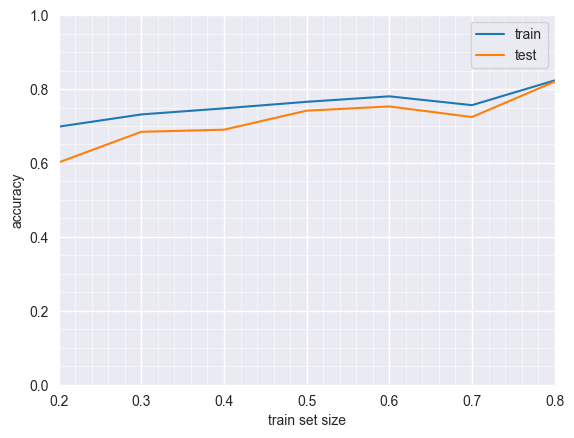

In [7]:
train_curve, test_curve = [], []
for scores_dict in history.values():
    train_accuracy, test_accuracy = [], []
    for split in scores_dict.values():
        train_accuracy.append(split['train_accuracy'])
        test_accuracy.append(split['test_accuracy'])
    train_curve.append(np.mean(train_accuracy))
    test_curve.append(np.mean(test_accuracy))
plt.plot(TRAIN_SIZES, train_curve, label='train')
plt.plot(TRAIN_SIZES, test_curve, label='test')
plt.xlabel('train set size')
plt.ylabel('accuracy')
plt.xlim(0.2, 0.8)
plt.ylim(0, 1)
plt.grid(which='major', axis='both', linewidth=1)
plt.grid(which='minor', axis='both', linewidth=0.4)
plt.minorticks_on()
plt.legend()